In [1]:
import math
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
proj_folder = "/content/drive/MyDrive/machine_learning/FYPTinyDiffusion/diffusion_winnet"

In [4]:
import sys
sys.path.append(proj_folder)
sys.path.append(f"{proj_folder}/winnet")

## Prepare the Dataset

In [5]:
def sigmoid_noise_level(t, T):
    """
    Args
        t (int or Tensor): integer time-step 0 ... T-1
        T (int): total number of steps.
    Returns
        noise_level in [0, 1] - larger => more noise.
    """
    x = (t / T) * 12.0 - 6.0
    return 1.0 / (1.0 + torch.exp(-x))

In [6]:
class NoisyCIFAR10(Dataset):
    """Returns (noise_image, t, clean_image)"""
    def __init__(
        self,
        root="./data",
        train=True,
        download=True,
        T=1000,
        transform=None
    ):
        self.T = T
        self.clean_set = datasets.CIFAR10(
            root=root,
            train=train,
            download=download,
            transform=transforms.ToTensor(),
        )
        self.extra_tf = transform

    def __len__(self):
        return len(self.clean_set)

    def __getitem__(self, idx):
        clean_img, _ = self.clean_set[idx] # ignore class label
        if self.extra_tf is not None:
            clean_image = self.extra_tf(clean_img)

        # sample a random timestep
        t = torch.randint(low=0, high=self.T, size=(1,), dtype=torch.long)

        # convert t to sigma via the sigmoid noise schedule
        noise_level = sigmoid_noise_level(t.float(), self.T)
        sigma = noise_level.sqrt()

        # add Gaussian noise
        noise = torch.randn_like(clean_img) * sigma
        noisy_img = clean_img + noise
        noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
        return noisy_img, t.squeeze(0), clean_img

In [ ]:
ds = NoisyCIFAR10(T=1000)
loader = DataLoader(ds, batch_size=8, shuffle=True, num_workers=2)

noisy, t, clean = ds[random.randrange(len(ds))]

print(f"Noisy image shape: {noisy.shape}")
print(f"Clean image shape: {clean.shape}")
print(f"Time-step t: {t.item()} (0 <= t < {ds.T})")

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Noisy image shape: torch.Size([3, 32, 32])
Clean image shape: torch.Size([3, 32, 32])
Time-step t: 413 (0 <= t < 1000)


In [ ]:
def img_to_np(x):
    x = x.detach().cpu().numpy().transpose(1, 2, 0)
    return (x * 255).astype(np.uint8)

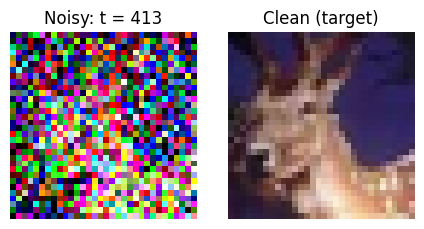

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.3))
axes[0].imshow(img_to_np(noisy))
axes[0].set_title(f"Noisy: t = {t.item()}")
axes[0].axis("off")

axes[1].imshow(img_to_np(clean))
axes[1].set_title("Clean (target)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Train the Model

In [ ]:
# train_denoiser.py
import time
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import MSELoss

In [ ]:
from unet import UNet

In [ ]:
init_params = {
    "UNet": {
        "base_channels": 64,
        "channel_multipliers": (1, 2, 4, 8),
        "in_channels": 3
    },
}

In [ ]:
model = UNet(**init_params["UNet"])

In [ ]:
param_count = sum(p.numel() for p in model.parameters())
param_count

35711491

In [ ]:
BATCH_SIZE = 128
EPOCHS      = 20
LR          = 1e-4
T_STEPS     = 1_000      # keep same as in dataset / model
NUM_WORKERS = 4

In [ ]:
train_set = NoisyCIFAR10(train=True,  T=T_STEPS)
val_set   = NoisyCIFAR10(train=False, T=T_STEPS)

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_set,   batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)
crit   = MSELoss()
opt    = AdamW(model.parameters(), lr=LR)

In [ ]:
def train_denoiser(
    model,
    device,
    crit,
    opt,
    train_loader,
    val_loader
):
    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        tic = time.time()

        # ---- TRAIN -------------------------------------------------------
        model.train()
        running_loss = 0.0

        for noisy, t, clean in train_loader:
            noisy, t, clean = noisy.to(device), t.to(device), clean.to(device)

            pred  = model(noisy, t)       # expected signature: f(x, t) -> denoised
            loss  = crit(pred, clean)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item() * noisy.size(0)

        train_mse = running_loss / len(train_loader.dataset)
        train_losses.append(train_mse)

        # ---- VALIDATE ----------------------------------------------------
        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for noisy, t, clean in val_loader:
                noisy, t, clean = noisy.to(device), t.to(device), clean.to(device)
                pred  = model(noisy, t)
                loss  = crit(pred, clean)
                val_running += loss.item() * noisy.size(0)

        val_mse = val_running / len(val_loader.dataset)
        val_losses.append(val_mse)
        epoch_time = time.time() - tic

        # ---- LOG ---------------------------------------------------------
        print(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train MSE: {train_mse:.6f} | "
            f"Val MSE: {val_mse:.6f} | "
            f"Time: {epoch_time:.1f}s"
        )

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_denoiser(
    model, device, crit, opt, train_loader, val_loader
)

Epoch 01/50 | Train MSE: 0.023099 | Val MSE: 0.014602 | Time: 114.2s
Epoch 02/50 | Train MSE: 0.013460 | Val MSE: 0.012567 | Time: 112.9s
Epoch 03/50 | Train MSE: 0.012165 | Val MSE: 0.011831 | Time: 112.7s
Epoch 04/50 | Train MSE: 0.011620 | Val MSE: 0.011440 | Time: 112.7s
Epoch 05/50 | Train MSE: 0.011188 | Val MSE: 0.011214 | Time: 112.7s
Epoch 06/50 | Train MSE: 0.011072 | Val MSE: 0.010941 | Time: 112.4s
Epoch 07/50 | Train MSE: 0.010864 | Val MSE: 0.010873 | Time: 112.4s
Epoch 08/50 | Train MSE: 0.010819 | Val MSE: 0.010764 | Time: 112.7s
Epoch 09/50 | Train MSE: 0.010678 | Val MSE: 0.010692 | Time: 112.6s
Epoch 10/50 | Train MSE: 0.010675 | Val MSE: 0.010872 | Time: 112.2s
Epoch 11/50 | Train MSE: 0.010553 | Val MSE: 0.010547 | Time: 112.5s
Epoch 12/50 | Train MSE: 0.010561 | Val MSE: 0.010556 | Time: 112.5s
Epoch 13/50 | Train MSE: 0.010478 | Val MSE: 0.010459 | Time: 112.5s
Epoch 14/50 | Train MSE: 0.010459 | Val MSE: 0.010517 | Time: 112.6s
Epoch 15/50 | Train MSE: 0.010393 

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Denoising Model")
plt.grid()
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 640x480 with 0 Axes>

## Saving the Model

In [ ]:
from datetime import datetime
import json

In [ ]:
results_folder = "drive/MyDrive/machine_learning/FYPTinyDiffusion/results"
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%d%b_%H%M")
CKPT_PATH = f"{results_folder}/cifar_denoiser_{formatted_datetime}.pt"

In [ ]:
model.eval()

# init_params is assumed to be a dict you created when instantiating the model
torch.save({"model_state_dict": model.state_dict(),
            "init_params": init_params},
           CKPT_PATH)
print(f"✓ checkpoint written to {CKPT_PATH}")

✓ checkpoint written to drive/MyDrive/machine_learning/FYPTinyDiffusion/results/cifar_denoiser_28May_2313.pt


## Evaluate the Model

In [7]:
import torch, random, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from unet import UNet

In [66]:
results_folder = "drive/MyDrive/machine_learning/FYPTinyDiffusion/results"
model_name = "cifar_large_unet_28May_2313"

In [ ]:
CKPT_PATH = f"{results_folder}/{model_name}.pt"
T_STEPS    = 1_000
BATCH      = 256
NUM_WORKER = 4
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# restore model + its init params
ckpt  = torch.load(CKPT_PATH, map_location=device)
model = UNet(**ckpt["init_params"]["UNet"]).to(device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("✓ model loaded")

✓ model loaded


In [10]:
test_set = datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transforms.ToTensor()
)
test_loader = DataLoader(
    test_set, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKER, pin_memory=True
)

100%|██████████| 170M/170M [00:18<00:00, 9.28MB/s]


In [13]:
import torch
import torch.nn.functional as F
from torch import nn

def calculate_psnr(pred: torch.Tensor, clean: torch.Tensor, max_val: float = 1.0) -> torch.Tensor:
    """
    Calculate PSNR between predicted and clean images.

    Args:
        pred (torch.Tensor): Predicted images of shape (B, C, H, W).
        clean (torch.Tensor): Ground truth images of shape (B, C, H, W).
        max_val (float): Maximum possible pixel value (e.g., 1.0 for normalized, 255 for 8-bit).

    Returns:
        torch.Tensor: PSNR value averaged over the batch.
    """
    mse = F.mse_loss(pred, clean, reduction='none')
    mse_per_image = mse.view(mse.shape[0], -1).mean(dim=1)  # Mean per image in batch

    # Avoid division by zero
    psnr = 10 * torch.log10((max_val ** 2) / (mse_per_image + 1e-8))

    return psnr.mean()  # Return average PSNR over the batch


In [14]:
def gaussian_window(window_size: int, sigma: float, channels: int) -> torch.Tensor:
    coords = torch.arange(window_size).float() - window_size // 2
    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g = g / g.sum()
    window_1d = g.unsqueeze(0)
    window_2d = (window_1d.T @ window_1d).unsqueeze(0).unsqueeze(0)
    window = window_2d.expand(channels, 1, window_size, window_size).contiguous()
    return window

def calculate_ssim(pred: torch.Tensor, clean: torch.Tensor, window_size: int = 11, sigma: float = 1.5, max_val: float = 1.0) -> torch.Tensor:
    """
    Calculate SSIM between predicted and clean images.

    Args:
        pred (torch.Tensor): Predicted images of shape (B, C, H, W).
        clean (torch.Tensor): Ground truth images of shape (B, C, H, W).
        window_size (int): Size of the Gaussian window.
        sigma (float): Standard deviation of the Gaussian window.
        max_val (float): Maximum possible pixel value (e.g., 1.0 for normalized, 255 for 8-bit).

    Returns:
        torch.Tensor: SSIM value averaged over the batch.
    """
    C1 = (0.01 * max_val) ** 2
    C2 = (0.03 * max_val) ** 2

    _, channels, _, _ = pred.size()
    window = gaussian_window(window_size, sigma, channels).to(pred.device)

    mu1 = F.conv2d(pred, window, padding=window_size // 2, groups=channels)
    mu2 = F.conv2d(clean, window, padding=window_size // 2, groups=channels)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(pred * pred, window, padding=window_size // 2, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(clean * clean, window, padding=window_size // 2, groups=channels) - mu2_sq
    sigma12 = F.conv2d(pred * clean, window, padding=window_size // 2, groups=channels) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()


In [41]:
def calculate_mse(pred: torch.Tensor, clean: torch.Tensor) -> torch.Tensor:
    """
    Calculate Mean Squared Error (MSE) between predicted and clean images.

    Args:
        pred (torch.Tensor): Predicted images of shape (B, C, H, W).
        clean (torch.Tensor): Ground truth images of shape (B, C, H, W).

    Returns:
        torch.Tensor: MSE value averaged over the batch.
    """
    return torch.mean((pred - clean) ** 2)


In [42]:
LEVELS = [0, 50, 100, 250, 500, 750, 999]        # diffusion steps to test
sigmas = [sigmoid_noise_level(torch.tensor(t), T_STEPS).sqrt().item()
          for t in LEVELS]

In [43]:
def eval_level(t_step: int):
    sigma = sigmoid_noise_level(torch.tensor(t_step), T_STEPS).sqrt()
    psnr_sum, ssim_sum, mse_sum, n_img = 0.0, 0.0, 0.0, 0

    with torch.no_grad():
        for clean, _ in test_loader:
            clean = clean.to(device)
            noisy = torch.clamp(clean + torch.randn_like(clean) * sigma, 0., 1.)

            pred  = model(noisy,
                          torch.full((noisy.size(0),), t_step,
                                     dtype=torch.long, device=device))

            psnr_sum += calculate_psnr(pred, clean).item()
            ssim_sum += calculate_ssim(pred, clean).item()
            mse_sum = calculate_mse(pred, clean).item()

        psnr_mean = psnr_sum / len(test_loader)
        ssim_mean = ssim_sum / len(test_loader)
        mse_mean = mse_sum / len(test_loader)

    return psnr_mean, ssim_mean, mse_mean

In [48]:
# 4.  EVALUATE & PRINT

metric_names_vals = {
    "t": LEVELS,
    "sigma": sigmas,
    "PSNR": [],
    "SSIM": [],
    "MSE": [],
}

for t, σ in zip(LEVELS, sigmas):
    p, s, mse = eval_level(t)
    metric_names_vals["PSNR"].append(p)
    metric_names_vals["SSIM"].append(s)
    metric_names_vals["MSE"].append(mse)
    print(f"t={t:4d} | σ={σ:.3f} | PSNR {p:.2f} dB | SSIM {s:.4f} | MSE {mse:.4f}")

t=   0 | σ=0.050 | PSNR 30.81 dB | SSIM 0.9625 | MSE 0.0000
t=  50 | σ=0.067 | PSNR 29.64 dB | SSIM 0.9521 | MSE 0.0000
t= 100 | σ=0.090 | PSNR 28.43 dB | SSIM 0.9371 | MSE 0.0000
t= 250 | σ=0.218 | PSNR 24.50 dB | SSIM 0.8611 | MSE 0.0001
t= 500 | σ=0.707 | PSNR 19.37 dB | SSIM 0.6634 | MSE 0.0003
t= 750 | σ=0.976 | PSNR 18.15 dB | SSIM 0.6008 | MSE 0.0004
t= 999 | σ=0.999 | PSNR 18.07 dB | SSIM 0.5975 | MSE 0.0005


In [49]:
import pandas as pd

In [50]:
df = pd.DataFrame.from_dict(metric_names_vals)
df

,t,sigma,PSNR,SSIM,MSE
0,0,0.049725,30.808128,0.962497,0.000022
1,50,0.067054,29.642379,0.952145,0.000028
2,100,0.090347,28.426303,0.937148,0.000037
3,250,0.217775,24.496949,0.861092,0.000095
4,500,0.707107,19.370099,0.663433,0.000335
5,750,0.975999,18.150160,0.600831,0.000450
6,999,0.998748,18.070064,0.597491,0.000483


In [67]:
print(results_folder)
print(model_name)

drive/MyDrive/machine_learning/FYPTinyDiffusion/results
cifar_large_unet_28May_2313


In [71]:
# save the df as a csv file
csv_path = f"{results_folder}/{model_name}.csv"
df.to_csv(csv_path, index=False)
print(f"metrics dataframe saved to\n{csv_path}")

metrics dataframe saved to
drive/MyDrive/machine_learning/FYPTinyDiffusion/results/cifar_large_unet_28May_2313.csv


In [62]:
import matplotlib.pyplot as plt

def plot_metrics_against_sigma(df):
    """
    Plots PSNR, SSIM, and MSE against sigma in vertically stacked subplots.

    Args:
        df (pd.DataFrame): DataFrame with columns 'sigma', 'PSNR', 'SSIM', and 'MSE'.
    """
    fig, axs = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

    # Plot PSNR
    axs[0].plot(df['sigma'], df['PSNR'], marker='o')
    axs[0].set_ylabel('PSNR (dB)')
    axs[0].set_title('PSNR vs Sigma')
    axs[0].grid(True)

    # Plot SSIM
    axs[1].plot(df['sigma'], df['SSIM'], marker='o')
    axs[1].set_ylabel('SSIM')
    axs[1].set_title('SSIM vs Sigma')
    axs[1].grid(True)

    # Plot MSE
    axs[2].plot(df['sigma'], df['MSE'], marker='o')
    axs[2].set_ylabel('MSE')
    axs[2].set_title('MSE vs Sigma')
    axs[2].set_xlabel('Sigma')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

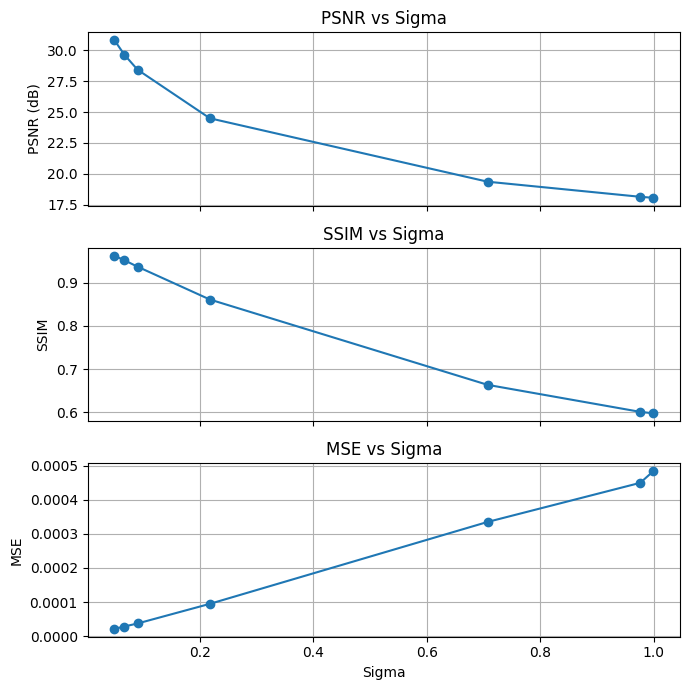

In [63]:
plot_metrics_against_sigma(df)

In [ ]:
n_cols = 10                                       # images per row
row_titles = ["Noisy", "Denoised", "Clean"]

# choose n_cols random test indices once per run
indices = random.sample(range(len(test_set)), n_cols)
clean_subset = torch.stack([test_set[i][0] for i in indices]).to(device)

with torch.no_grad():
    for t, σ in zip(LEVELS, sigmas):
        noisy  = torch.clamp(clean_subset + torch.randn_like(clean_subset) * σ, 0., 1.)
        denoised = model(noisy,
                         torch.full((n_cols,), t, dtype=torch.long, device=device))

        # compose grid: row0=noisy, row1=denoised, row2=clean
        grid = torch.cat([noisy.cpu(),
                          denoised.cpu(),
                          clean_subset.cpu()], dim=0)
        grid = make_grid(grid, nrow=n_cols, padding=2)

        plt.figure(figsize=(1.3*n_cols, 4))
        plt.imshow(to_pil_image(grid))
        plt.axis("off")
        plt.title(f"Denoising results  –  σ = {σ:.3f}  (t = {t})")
        # for r, txt in enumerate(row_titles):
        #     plt.text(-0.5, (r+0.5)/3, txt, va="center",
        #              ha="right", fontsize=12, transform=plt.gca().transAxes)
        plt.show()

Output hidden; open in https://colab.research.google.com to view.